In [1]:
from IPython.core.display import HTML
display(HTML('<style>.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:'
             + 'empty {padding: 0; border: 0;}</style>'));

In [2]:
import os, sys, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from glob import glob
from PIL import Image
from copy import deepcopy

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
import torch, torchvision
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
sys.path.append('../mouseland/model_opts')
from feature_extraction import *
from model_options import *
from image_ops import *

In [61]:
#import pingouin as pg
#from plotnine import *
#import plotnine.options as plotnine_options

In [6]:
model_options = get_model_options()
image_transforms = get_image_transforms()['imagenet']

In [18]:
response_data = pd.read_csv('oasis_means_per_image.csv')
response_data['thing'] = response_data['theme'].str.replace('\d+', '',  regex=True)
response_data['image_name'] = response_data['theme'] + '.jpg'

In [33]:
response_data['category'].value_counts()

Person    346
Scene     220
Object    200
Animal    134
Name: category, dtype: int64

In [63]:
response_data['valence'].min(), response_data['valence'].max()

(1.11, 6.49)

In [62]:
pg.pairwise_corr(response_data, columns = ['beauty','arousal','valence'])

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,BF10,power
0,beauty,arousal,pearson,two-sided,900,0.155386,"[0.09, 0.22]",0.024145,0.021969,0.156655,2.819085e-06,2378.08,0.996874
1,beauty,valence,pearson,two-sided,900,0.754776,"[0.73, 0.78]",0.569687,0.568727,0.983962,1.307025e-166,4.859e+162,1.000000
2,arousal,valence,pearson,two-sided,900,-0.058188,"[-0.12, 0.01]",0.003386,0.001164,-0.058253,8.104072e-02,0.191,0.415199


In [8]:
root = 'oasis_assets/'
assets = glob(root + '*.jpg')
dictlist = []
for asset in assets:
    imgstr = asset.split('/')[1]
    row = {'image_name': imgstr}
    dictlist.append(row)
image_df = pd.DataFrame(dictlist).sort_values(by='image_name', ignore_index=True)
print(image_df)

       image_name
0     Acorns1.jpg
1     Acorns2.jpg
2     Acorns3.jpg
3    Alcohol1.jpg
4    Alcohol2.jpg
..            ...
895     Yoga2.jpg
896     Yoga3.jpg
897     Yoga4.jpg
898     Yoga5.jpg
899    Zebra1.jpg

[900 rows x 1 columns]


In [9]:
class StimulusSet(Dataset):
    def __init__(self, csv, root_dir, image_transforms=None):
        
        self.root = os.path.expanduser(root_dir)
        self.transforms = image_transforms
        
        if isinstance(csv, pd.DataFrame):
            self.df = csv
        if isinstance(csv, str):
            self.df = pd.read_csv(csv)
        
        self.images = self.df.image_name

    def __getitem__(self, index):
        filename = os.path.join(self.root, self.images.iloc[index])
        img = Image.open(filename).convert('RGB')
        
        if self.transforms:
            img = self.transforms(img)
            
        return img
    
    def __len__(self):
        return len(self.images)

In [10]:
stimulus_loader = DataLoader(dataset=StimulusSet(image_df, root, image_transforms), batch_size=64)

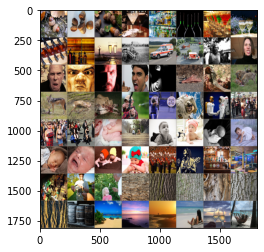

In [11]:
get_dataloader_sample(stimulus_loader)

In [14]:
model_string = 'alexnet_imagenet'
model_name = model_options[model_string]['model_name']
train_type = model_options[model_string]['train_type']
model_call = model_options[model_string]['call']

model = eval(model_call)
model = model.eval()
model = model.cuda()

In [15]:
stimulus_features = get_all_feature_maps(model, stimulus_loader, numpy=False)

  0%|          | 0/15 [00:00<?, ?it/s]

In [20]:
response_data = deepcopy(image_df).merge(response_data, on = 'image_name')

In [21]:
from sklearn.linear_model import RidgeCV
from scipy.stats import pearsonr

In [24]:
y_sub = response_data.query("category == 'Scene'")
y_ind = y_sub.index.to_numpy()
y = y_sub.beauty.to_numpy()
X = stimulus_features['Conv2d-1'].numpy()[y_ind,:]

In [25]:
alpha_values = np.logspace(-1,10,100)
regression = RidgeCV(alphas=alpha_values, store_cv_values=True, 
                     scoring='explained_variance').fit(X,y)
regression.best_score_, regression.alpha_

(0.11383392819233484, 359381.36638046254)

In [28]:
alpha_values = np.logspace(-1,10,100)
regression = RidgeCV(alphas=alpha_values, store_cv_values=True, 
                     scoring='explained_variance').fit(X_mean.reshape(-1,1),y)
regression.best_score_, np.round(regression.alpha_, 5)

(0.0023890068700234135, 0.304)

In [84]:
reg_results = []
for model_layer in tqdm(stimulus_features):
    y_sub = response_data.query("category == 'Scene'")
    y_ind = y_sub.index.to_numpy()
    y = y_sub.beauty.to_numpy()
    X = stimulus_features[model_layer].numpy()[y_ind,:]
    alpha_values = np.logspace(-1,10,100)
    regression = RidgeCV(alphas=alpha_values, store_cv_values=True, 
                         scoring='explained_variance').fit(X,y)
    reg_results.append({'model_layer': model_layer, 
                        'reg_score': regression.best_score_,
                        'cor_score': pearsonr(y, X.mean(axis=1))[0]})
    
pd.DataFrame(reg_results)

  0%|          | 0/18 [00:00<?, ?it/s]

,model_layer,reg_score,cor_score
0,Conv2d-1,0.113834,0.131624
1,ReLU-1,0.351331,-0.260467
2,MaxPool2d-1,0.347916,-0.401328
3,Conv2d-2,0.329810,0.403099
4,ReLU-2,0.419658,0.058582
5,MaxPool2d-2,0.452298,-0.145183
6,Conv2d-3,0.427406,0.116502
7,ReLU-3,0.479125,-0.265911
8,Conv2d-4,0.465129,0.196373
9,ReLU-4,0.485705,-0.204696


In [47]:
reg_dictlist = []
for model_layer_index, model_layer in enumerate(tqdm(stimulus_features)):
    target_features = stimulus_features[model_layer].numpy()
    
    for category in response_data['category'].unique().tolist() + ['Combo']:
        if category != 'Combo':
            response_data_sub = response_data.query("category == '{}'".format(category))
            image_indices = response_data_sub.index.to_numpy()
        if category == 'Combo':
            response_data_sub = response_data
            image_indices = response_data_sub.index.to_numpy()
            
        for measurement in ['arousal','valence','beauty']:
        
            y = response_data_sub[measurement].to_numpy()
            X = target_features[image_indices,:]
            regression = RidgeCV(alphas=np.logspace(-1,10,100), store_cv_values=True, 
                                 scoring='explained_variance').fit(X,y)
        
            reg_dictlist.append({'model': model_name, 'train_type': train_type, 
                                 'model_layer': model_layer, 
                                 'model_layer_depth': model_layer_index+1, 
                                 'category': category, 'measurement': measurement,
                                 'score': regression.best_score_, 'penalty': regression.alpha_})
        
    reg_results = pd.DataFrame(reg_dictlist)

  0%|          | 0/18 [00:00<?, ?it/s]

In [48]:
reg_results

,model,train_type,model_layer,model_layer_depth,category,measurement,score,penalty
0,alexnet,imagenet,Conv2d-1,1,Object,arousal,0.044273,2.782559e+06
1,alexnet,imagenet,Conv2d-1,1,Object,valence,0.034104,4.641589e+06
2,alexnet,imagenet,Conv2d-1,1,Object,beauty,0.028532,4.641589e+06
3,alexnet,imagenet,Conv2d-1,1,Person,arousal,-0.005808,1.000000e+10
4,alexnet,imagenet,Conv2d-1,1,Person,valence,0.017204,5.994843e+06
...,...,...,...,...,...,...,...,...
265,alexnet,imagenet,Linear-3,18,Scene,valence,0.527895,2.154435e+03
266,alexnet,imagenet,Linear-3,18,Scene,beauty,0.684805,2.154435e+03
267,alexnet,imagenet,Linear-3,18,Combo,arousal,0.409651,7.742637e+03
268,alexnet,imagenet,Linear-3,18,Combo,valence,0.357467,3.593814e+03


In [ ]:
reg_results.pivot(index = ['model','train_type','model_layer','model_layer_depth'], 
                  columns = 'category', values = 'score').reset_index().sort_values(by='model_layer_depth')

In [55]:
(reg_results[reg_results['model_layer_depth'] == 17].groupby(['category','measurement'])
 ['score'].mean().reset_index().sort_values(by='score'))

,category,measurement,score
9,Person,arousal,0.177242
0,Animal,arousal,0.277997
10,Person,beauty,0.298339
11,Person,valence,0.312492
8,Object,valence,0.332706
7,Object,beauty,0.372897
12,Scene,arousal,0.396262
5,Combo,valence,0.400861
3,Combo,arousal,0.422342
6,Object,arousal,0.467296


In [56]:
(reg_results[reg_results['model_layer_depth'] == 17].groupby(['measurement'])
 ['score'].mean().reset_index().sort_values(by='score'))

,measurement,score
0,arousal,0.348228
2,valence,0.420528
1,beauty,0.474670


In [66]:
pg.pairwise_ttests(reg_results[reg_results['model_layer_depth'] == 17],
                   dv = 'score', between = 'measurement', padjust = 'bonf')

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,measurement,arousal,beauty,False,True,-1.471700,8.0,two-sided,0.179313,0.53794,bonf,0.91,-0.840709
1,measurement,arousal,valence,False,True,-1.022711,8.0,two-sided,0.336372,1.00000,bonf,0.673,-0.584224
2,measurement,beauty,valence,False,True,0.658285,8.0,two-sided,0.528840,1.00000,bonf,0.563,0.376045


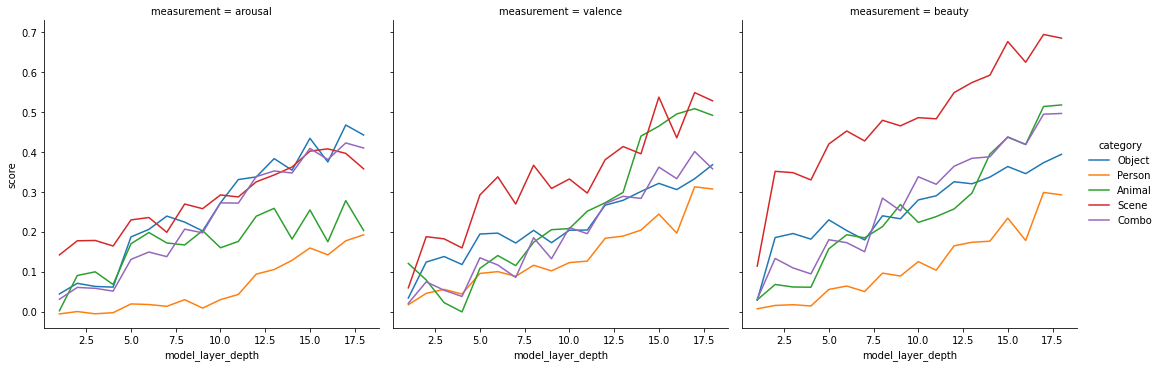

In [49]:
sns.relplot(x = 'model_layer_depth', y = 'score', hue = 'category', 
            col = 'measurement', kind = 'line', data = reg_results);